# Data Exploration

In [6]:
%run setup.py

time: 48.9 s (started: 2021-08-07 13:38:31 +00:00)


In [7]:
train.head()

,pickup_date,total_rides,total_takings
0,2013-08-01,307272,4.567414e+06
1,2013-08-02,236761,3.534616e+06
2,2013-08-03,226554,3.182267e+06
3,2013-08-04,202310,3.073609e+06
4,2013-08-05,406487,6.657713e+06


time: 8.19 ms (started: 2021-08-07 13:39:20 +00:00)


## MLFlow Setup

In [8]:
import mlflow

time: 1.57 s (started: 2021-08-07 13:39:20 +00:00)


In [9]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/
time: 460 µs (started: 2021-08-07 13:39:21 +00:00)


The taxi_daily_forecast experiment has already been created

In [19]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.ets import AutoETS
import numpy as np

time: 478 µs (started: 2021-08-07 14:05:47 +00:00)


In [ ]:
# forescasting horizon
# window_length
# step_length

In [15]:
cv = SlidingWindowSplitter(fh=7, window_length=28, step_length=7)

time: 261 µs (started: 2021-08-07 14:04:12 +00:00)


In [59]:
# check the split points
cv.get_cutoffs(y=train['total_rides'])

array([ 27,  34,  41,  48,  55,  62,  69,  76,  83,  90,  97, 104, 111,
       118, 125, 132, 139, 146, 153, 160, 167, 174, 181, 188, 195, 202,
       209, 216, 223, 230, 237, 244, 251, 258, 265, 272, 279, 286, 293,
       300, 307, 314, 321, 328, 335, 342, 349, 356, 363, 370, 377, 384,
       391, 398, 405, 412, 419, 426, 433, 440, 447, 454, 461, 468, 475,
       482, 489, 496, 503, 510, 517, 524, 531, 538, 545, 552, 559, 566,
       573, 580, 587, 594, 601, 608, 615, 622, 629, 636, 643, 650, 657,
       664, 671, 678, 685, 692, 699, 706, 713, 720])

time: 3.37 ms (started: 2021-08-07 15:36:23 +00:00)


In [61]:
# check the number of splits
cv.get_n_splits(y=train['total_rides'])

100

time: 2.92 ms (started: 2021-08-07 15:40:23 +00:00)


## Fitting Models

In [34]:
from sktime.forecasting.model_evaluation import evaluate

time: 369 µs (started: 2021-08-07 14:13:55 +00:00)


In [21]:
fh = np.arange(1, 7)

time: 269 µs (started: 2021-08-07 14:09:52 +00:00)


In [51]:
forecaster = AutoETS(auto=True, sp=7, n_jobs=-1)

time: 539 µs (started: 2021-08-07 15:21:28 +00:00)


In [52]:
evaluation_results = evaluate(forecaster=forecaster, y=train['total_rides'].astype('float64'), 
         cv=cv, strategy="refit", return_data=True)

time: 9.35 s (started: 2021-08-07 15:21:32 +00:00)


In [53]:
evaluation_results.columns

Index(['test_MeanAbsolutePercentageError', 'fit_time', 'pred_time',
       'len_train_window', 'cutoff', 'y_train', 'y_test', 'y_pred'],
      dtype='object')

time: 1.76 ms (started: 2021-08-07 15:21:41 +00:00)


In [55]:
evaluation_results.head()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.035610,1.449914,0.002463,28,27.0,0 307272.0 1 236761.0 2 226554.0 3...,"34 454753.0 Name: total_rides, dtype: float64",34 438842.504435 dtype: float64
1,0.176606,0.775813,0.002142,28,34.0,7 437214.0 8 489393.0 9 445096.0 1...,"41 502234.0 Name: total_rides, dtype: float64",41 420733.058656 dtype: float64
2,0.037050,0.487826,0.001859,28,41.0,14 473737.0 15 450037.0 16 438308.0 1...,"48 486310.0 Name: total_rides, dtype: float64",48 504667.668809 dtype: float64
3,0.050979,0.060193,0.001745,28,48.0,21 471540.0 22 464846.0 23 448911.0 2...,"55 464088.0 Name: total_rides, dtype: float64",55 488365.658991 dtype: float64
4,0.030689,0.068946,0.002405,28,55.0,28 456095.0 29 457632.0 30 435400.0 3...,"62 478552.0 Name: total_rides, dtype: float64",62 464087.692751 dtype: float64


time: 19.6 ms (started: 2021-08-07 15:24:23 +00:00)


In [54]:
evaluation_results.y_test[0]

34    454753.0
Name: total_rides, dtype: float64

time: 2.13 ms (started: 2021-08-07 15:21:57 +00:00)


In [44]:
evaluation_results.index

RangeIndex(start=0, stop=100, step=1)

time: 1.44 ms (started: 2021-08-07 15:02:23 +00:00)


## Evaluating the results

<AxesSubplot:>

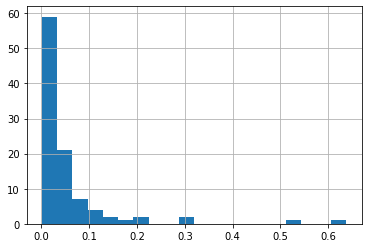

time: 93.9 ms (started: 2021-08-07 15:01:59 +00:00)


In [43]:
# histogram of fit loops
evaluation_results.test_MeanAbsolutePercentageError.hist(bins=20)